In [1]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_addons as tfa
import tensorflow_hub as hub 
from sklearn.metrics import mean_absolute_error 
import numpy as np 
import datetime
from keras_vggface.vggface import VGGFace

c:\Users\rtx40\anaconda3\envs\OCEAN-2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\rtx40\anaconda3\envs\OCEAN-2\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

### Load data

In [2]:
train_ds = tf.data.experimental.load('./data/videofaces_224/train_ds/') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

valid_ds = tf.data.experimental.load('./data/videofaces_224/val_ds') \
    .cache().shuffle(buffer_size=1000, seed=42).prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds, valid_ds

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 10, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>)

### Load VGGFace

In [3]:
# Load model VGGFace
vggface = VGGFace(include_top=False, model='vgg16', weights='vggface', pooling='max')

# Membekukan layer agar tidak dilatih ulang
vggface.trainable = False

# Memastikan struktur model VGGFace
vggface.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1_1 (Conv2D)            (None, None, None, 64)    1792      
                                                                 
 conv1_2 (Conv2D)            (None, None, None, 64)    36928     
                                                                 
 pool1 (MaxPooling2D)        (None, None, None, 64)    0         
                                                                 
 conv2_1 (Conv2D)            (None, None, None, 128)   73856     
                                                                 
 conv2_2 (Conv2D)            (None, None, None, 128)   147584    
                                                                 
 pool2 (MaxPooling2D)        (None, None, None, 128) 

### Build Face Model

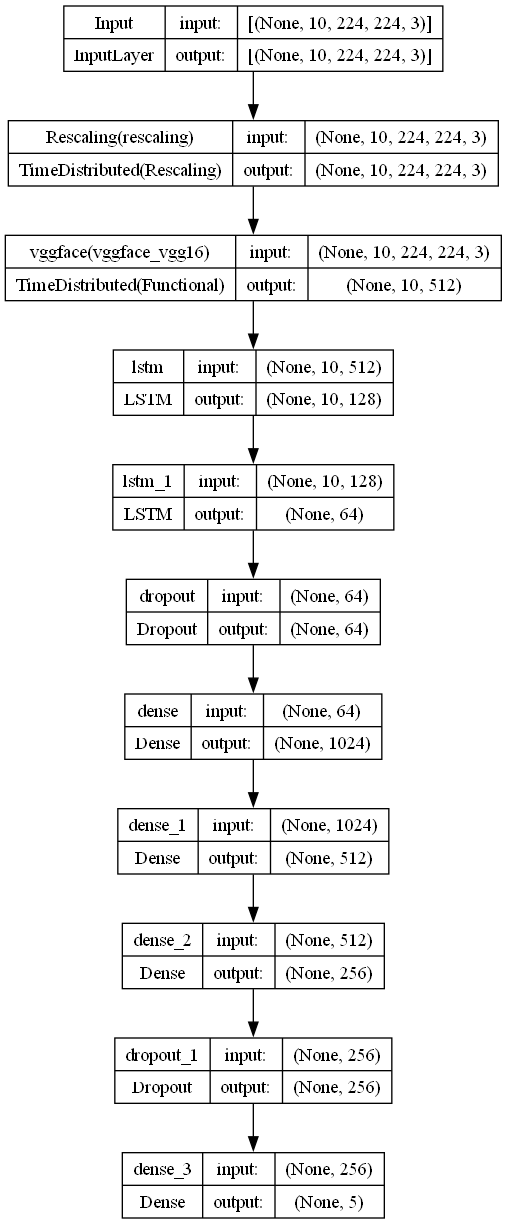

In [4]:
inputs = keras.layers.Input(shape=(10, 224, 224, 3), name='Input')

x = keras.layers.TimeDistributed(keras.layers.Rescaling(scale=1./255.0), name='Rescaling')(inputs)
x = keras.layers.TimeDistributed(vggface, name='vggface')(x)

x = keras.layers.LSTM(units=128, return_sequences=True)(x)
x = keras.layers.LSTM(units=64)(x)

x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(units=1024)(x)
x = keras.layers.Dense(units=512, activation='relu')(x)  

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(5, activation='sigmoid')(x)  

# Definisi model
model = keras.models.Model(inputs=inputs, outputs=x)

# Menampilkan arsitektur model
keras.utils.plot_model(model, show_shapes=True)

### Compile model

In [5]:
import datetime
import os
from tensorflow import keras

# Membuat timestamp untuk penamaan file
t = datetime.datetime.now().strftime("%m%d_%H%M%S")

# Menggunakan optimizer Adam
optimizer = keras.optimizers.Adam()

# Membuat folder untuk checkpoint jika belum ada
checkpoint_dir = f'./weights/face/{t}/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(patience=10, verbose=0)
check_point = keras.callbacks.ModelCheckpoint(
    filepath=f'./weights/face/{t}/face.t5',  
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

# Compile model
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

# Print konfirmasi
print(f"[INFO] Model dikompilasi dengan Adam optimizer. Checkpoint disimpan di '{checkpoint_dir}face.t5'")


[INFO] Model dikompilasi dengan Adam optimizer. Checkpoint disimpan di './weights/face/0415_121856/face.t5'


### Train

In [ ]:
history = model.fit(train_ds, validation_data=valid_ds, batch_size=8, epochs=100, callbacks=[early_stopping, check_point])
# 0415_121856 - 136m 30s

Epoch 1/100
750/750 [==============================] - 289s 284ms/step - loss: 0.0218 - mae: 0.1185 - val_loss: 0.0194 - val_mae: 0.1119
Epoch 2/100
750/750 [==============================] - 210s 281ms/step - loss: 0.0205 - mae: 0.1146 - val_loss: 0.0184 - val_mae: 0.1085
Epoch 3/100
750/750 [==============================] - 214s 285ms/step - loss: 0.0203 - mae: 0.1142 - val_loss: 0.0203 - val_mae: 0.1143
Epoch 4/100
750/750 [==============================] - 225s 300ms/step - loss: 0.0194 - mae: 0.1116 - val_loss: 0.0189 - val_mae: 0.1105
Epoch 5/100
750/750 [==============================] - 222s 296ms/step - loss: 0.0188 - mae: 0.1096 - val_loss: 0.0174 - val_mae: 0.1058
Epoch 6/100
750/750 [==============================] - 216s 288ms/step - loss: 0.0183 - mae: 0.1080 - val_loss: 0.0172 - val_mae: 0.1048
Epoch 7/100
750/750 [==============================] - 218s 290ms/step - loss: 0.0182 - mae: 0.1081 - val_loss: 0.0170 - val_mae: 0.1043
Epoch 8/100
750/750 [====================

### Load Weights

In [7]:
model.load_weights('./weights/face/0415_121856/face.t5')

## Evaluation

### Training data

In [8]:
train_ds = tf.data.Dataset.load('./data/videofaces_224/train_ds') 
loss, mae = model.evaluate(train_ds)
(1-mae)*100

750/750 [==============================] - 73s 97ms/step - loss: 0.0107 - mae: 0.0825


91.75210893154144

In [9]:
y_true = np.concatenate([y for x,y in train_ds])
y_pred = model.predict(train_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

750/750 [==============================] - 73s 96ms/step


(array([91.655876, 91.44499 , 92.14538 , 91.8392  , 91.6751  ],
       dtype=float32),
 91.75210893154144)

### Validation data

In [10]:
valid_ds = tf.data.experimental.load('./data/videofaces_224/val_ds/') 
loss, mae = model.evaluate(valid_ds)
(1-mae)*100

250/250 [==============================] - 24s 97ms/step - loss: 0.0146 - mae: 0.0960


90.39527475833893

In [11]:
y_true = np.concatenate([y for x,y in valid_ds])
y_pred = model.predict(valid_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

250/250 [==============================] - 24s 97ms/step


(array([90.307945, 90.1761  , 90.468346, 90.91388 , 90.110146],
       dtype=float32),
 90.3952844440937)

### Test data

In [12]:
test_ds = tf.data.experimental.load('./data/videofaces_224/test_ds')
loss, mae = model.evaluate(test_ds)
(1-mae)*100

250/250 [==============================] - 24s 97ms/step - loss: 0.0150 - mae: 0.0972


90.28475135564804

In [13]:
y_true = np.concatenate([y for x,y in test_ds])
y_pred = model.predict(test_ds)

mae = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
(1-mae)*100, (1-np.mean(mae))*100

250/250 [==============================] - 24s 97ms/step


(array([90.36286, 90.15109, 90.37789, 90.58034, 89.95158], dtype=float32),
 90.28474986553192)